In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# For data splitting
from sklearn.model_selection import train_test_split

# For scaling
from sklearn.preprocessing import StandardScaler

# For modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# For evaluation
from sklearn.metrics import mean_squared_error, r2_score

# For pipelines
from sklearn.pipeline import Pipeline

# For GridSearch
from sklearn.model_selection import GridSearchCV


## Create features and target variables, split the data into train and test

In [241]:
df = pd.read_csv('data/auto_scout_final.csv')

In [242]:
# Create features and targey variable
X = df.drop('price', axis = 1)
y = df['price']

In [243]:
X.shape

(15914, 158)

In [244]:
y.shape

(15914,)

In [245]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [246]:
X_train.shape

(11935, 158)

## scale the data (not using pipelines)


In [247]:
# Standard scaler
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train) # train the scalar on the train dataset
X_test_scaled = standard_scaler.transform(X_test) # transform test datasets, make sure you don't fit to test data though!

## try ols linear regression model (shouldn't matter if data is scaled or not?)

In [248]:
# initialise and train the model 
ols = LinearRegression()
ols.fit(X_train, y_train)

# make predictions
y_pred_ols = ols.predict(X_test)

# evaluate the model
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print(f"OLS MSE: {mse_ols:.2f}, R^2: {r2_ols:.2f}")


OLS MSE: 5559807.55, R^2: 0.89


## Ridge regression

In [249]:
# Initialize and train the model
ridge = Ridge(alpha=1.0)  # You can tune alpha
ridge.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test_scaled)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge MSE: {mse_ridge:.2f}, R^2: {r2_ridge:.2f}")

Ridge MSE: 5560078.37, R^2: 0.89


## Lasso regression

In [250]:
# Initialize and train the model
lasso = Lasso(alpha=0.1)  # You can tune alpha
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso MSE: {mse_lasso:.2f}, R^2: {r2_lasso:.2f}")

Lasso MSE: 5559628.97, R^2: 0.89


Pretty minimal differences in performance across different models here...
Also models trained very fast (2 secs), quite surprising given size of dataset? Means I can do gridsearch though...
Use negative of the MSE as our scoring metric so that GridSearchCV uses maximization, MSE is lower is better, so best params can be found when -MSE highest

In [251]:
# Perform GridSearch to try and optimise alpha for ridge and lasso regressions
# For Ridge Regression
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5) # MSE is good here, interested in minimising error here rather than explaining all the variance. squared means larger errors penalised more than small ones...
ridge_grid.fit(X_train_scaled, y_train)
print("Best Ridge alpha:", ridge_grid.best_params_['alpha'])

# For Lasso Regression
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train)
print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

Best Ridge alpha: 10
Best Lasso alpha: 1


In [252]:
# have a look at performance metrics across the grid for both models
# Ridge Regression results
ridge_results = pd.DataFrame(ridge_grid.cv_results_)

# Lasso Regression results
lasso_results = pd.DataFrame(lasso_grid.cv_results_)

In [253]:
# Select relevant columns
ridge_metrics = ridge_results[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Convert negative MSE to positive MSE
ridge_metrics['mean_test_MSE'] = -ridge_metrics['mean_test_score'] # calculate the positive version of the MSE by negating the mean_test_score (used neg_MSE in our GridSearchCV)
ridge_metrics['std_test_MSE'] = ridge_metrics['std_test_score']
ridge_metrics['meant_test_RMSE'] = ridge_metrics['mean_test_MSE'] ** 0.5 # root MSE is good because its on the same scale as the target variable
# Display the metrics
print("Ridge Regression Performance Metrics:")
print(ridge_metrics[['param_alpha', 'mean_test_MSE', 'std_test_MSE','meant_test_RMSE', 'rank_test_score']].sort_values(by = 'rank_test_score'))

Ridge Regression Performance Metrics:
   param_alpha  mean_test_MSE   std_test_MSE  meant_test_RMSE  rank_test_score
3        10.00   5.789026e+06  284244.307020      2406.039438                1
2         1.00   5.790285e+06  284897.908150      2406.301016                2
1         0.10   5.790456e+06  284973.711435      2406.336536                3
0         0.01   5.790473e+06  284981.412682      2406.340196                4
4       100.00   5.798025e+06  282742.834125      2407.908869                5


C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\3819835117.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_metrics['mean_test_MSE'] = -ridge_metrics['mean_test_score'] # calculate the positive version of the MSE by negating the mean_test_score (used neg_MSE in our GridSearchCV)
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\3819835117.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_metrics['std_test_MSE'] = ridge_metrics['std_test_score']
C:\Users\BalintStewart\AppDa

In [254]:
df.price.describe()

count    15914.000000
mean     18023.741171
std       7381.470484
min       4950.000000
25%      12850.000000
50%      16900.000000
75%      21900.000000
max      74600.000000
Name: price, dtype: float64

In [255]:
# Select relevant columns
lasso_metrics = lasso_results[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Convert negative MSE to positive MSE
lasso_metrics['mean_test_MSE'] = -lasso_metrics['mean_test_score']
lasso_metrics['std_test_MSE'] = lasso_metrics['std_test_score']
lasso_metrics['meant_test_RMSE'] = lasso_metrics['mean_test_MSE'] ** 0.5 # root MSE is good because its on the same scale as the target variable

# Display the metrics
print("Lasso Regression Performance Metrics:")
print(lasso_metrics[['param_alpha', 'mean_test_MSE', 'std_test_MSE', 'meant_test_RMSE','rank_test_score']].sort_values(by = 'rank_test_score'))

Lasso Regression Performance Metrics:
   param_alpha  mean_test_MSE   std_test_MSE  meant_test_RMSE  rank_test_score
4       1.0000   5.785709e+06  282434.329728      2405.350131                1
3       0.1000   5.789825e+06  284684.325241      2406.205530                2
2       0.0100   5.790409e+06  284952.082053      2406.326859                3
1       0.0010   5.790468e+06  284979.249297      2406.339226                4
0       0.0001   5.790474e+06  284981.967668      2406.340466                5
5      10.0000   5.811616e+06  276042.671246      2410.729410                6
6     100.0000   6.356398e+06  257394.082010      2521.189852                7


C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_metrics['mean_test_MSE'] = -lasso_metrics['mean_test_score']
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_metrics['std_test_MSE'] = lasso_metrics['std_test_score']
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Apply optimial alpha to Lasso. Can also use Lasso to simplify the model, by selection only the important features (where L1 penalty can shrink non-contributing coefficents to 0)

In [256]:
# Fit Lasso with the optimal alpha
lasso_optimal = Lasso(alpha=lasso_grid.best_params_['alpha'], max_iter=10000)
lasso_optimal.fit(X_train_scaled, y_train)

# Get coefficients
coefficients = pd.Series(lasso_optimal.coef_, index=X_train.columns)

# Identify non-zero coefficients
important_features = coefficients[coefficients != 0].index

# Reduce dataset to important features
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Retrain the model
lasso_optimal.fit(X_train_reduced, y_train)
y_pred_reduced = lasso_optimal.predict(X_test_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)

print(f"Reduced Lasso MSE: {mse_reduced:.2f}, R^2: {r2_reduced:.2f}")

Reduced Lasso MSE: 5552785.33, R^2: 0.89


In [257]:
X_train_reduced.shape # Most of the features have non-zero Lasso coefficients

(11935, 153)

Very little improvement of performance even with optimised alpha...

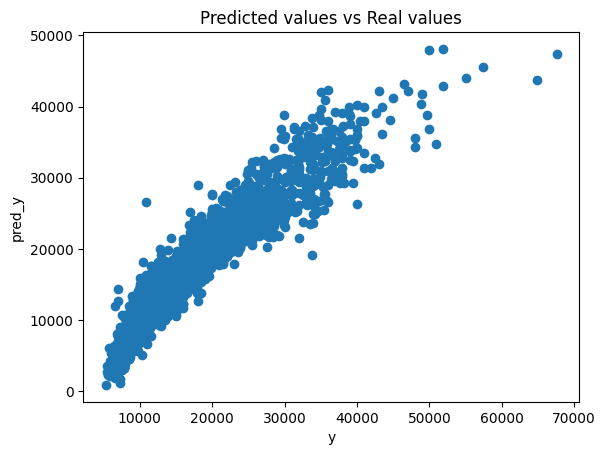

In [258]:
# Lok at predicted values plotted against real values
plt.scatter(y_test, y_pred_lasso)
plt.xlabel('y')
plt.ylabel('pred_y')
plt.title('Predicted values vs Real values')
plt.show()

Looks like we're underpredicting the more expensive cars, we can see this more clearly if we look at the residuals 

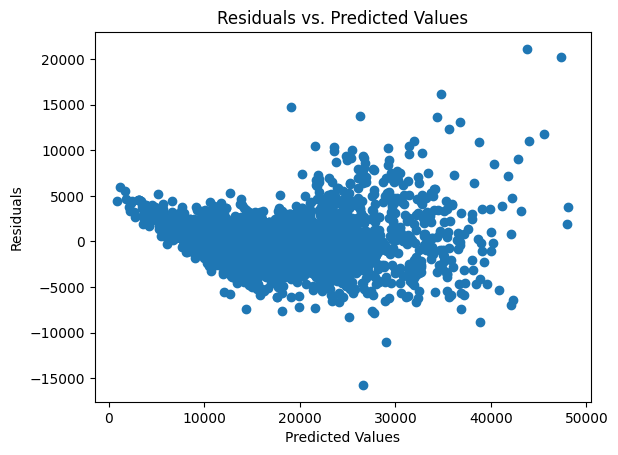

In [259]:
# Examine residuals
# Residuals
residuals = y_test - y_pred_lasso

# Residuals vs. Predicted
plt.scatter(y_pred_lasso, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Residuals vs predicted values plot:
If my model is performing well, i should see random scatter around 0 in resirdual plot. Model is performing quite well, although variance increasing as predicted values getting larger. Could be do to non-linear relationships in the data

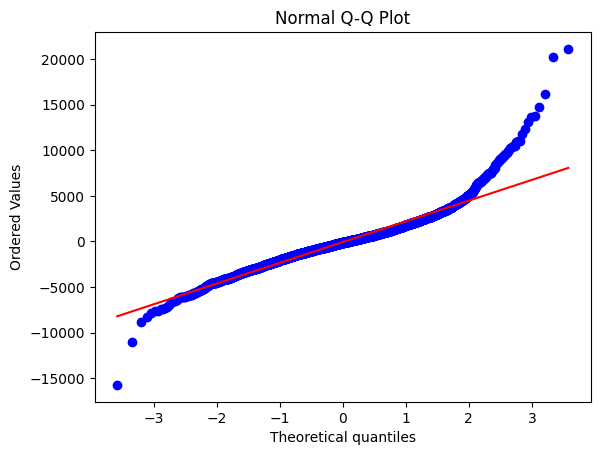

In [260]:
# Q-Q Plot (quantile-quantile plot) to look at the distribution of our residuals compared to normal distribution
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

Q-Q plot: are my residuals normally distributed? Middle part ~-2 to ~2 follow theoretical normal distribtion nicely, but there are heavy tails - more extreme low values and high values than expcted under a normal distribution.

One thing I can try to help with the data skewness is to log transform the target variable to try and stabilize the variance (log transf brings larger values closer together while spreading out smaller valiues)

In [261]:
# Apply log transformation to the target variable
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [262]:
# Initialize and train the model
lasso = Lasso(0.001) #use best params from before
lasso.fit(X_train_scaled, y_train_log)
# Make predictions
y_pred_log = lasso.predict(X_test_scaled)

#convert predictions back to normal scale
y_pred_original = np.exp(y_pred_log)


# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_original)
r2_lasso = r2_score(y_test, y_pred_original)

print(f"MSE: {mse_lasso:.2f}, R^2: {r2_lasso:.2f}, RMSE: {mse_lasso ** 0.5}")

MSE: 4453220.07, R^2: 0.91, RMSE: 2110.2654017208965


In [263]:
# Try a GridSearch for my log transformed target Lasso Regression
lasso_params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train_log)
print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

Best Lasso alpha: 0.0001


In [264]:
# Initialize and train the model
lasso = Lasso(alpha = 0.0001) #use best params from before
lasso.fit(X_train_scaled, y_train_log)

# Make predictions
y_pred_log = lasso.predict(X_test_scaled)

#convert predictions back to normal scale
y_pred_original = np.exp(y_pred_log)


# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_original)
r2_lasso = r2_score(y_test, y_pred_original)

print(f"MSE: {mse_lasso:.2f}, R^2: {r2_lasso:.2f}, RMSE: {mse_lasso ** 0.5}")

MSE: 4268903.89, R^2: 0.92, RMSE: 2066.1325930900325


RMSE of $2066 my best so far...

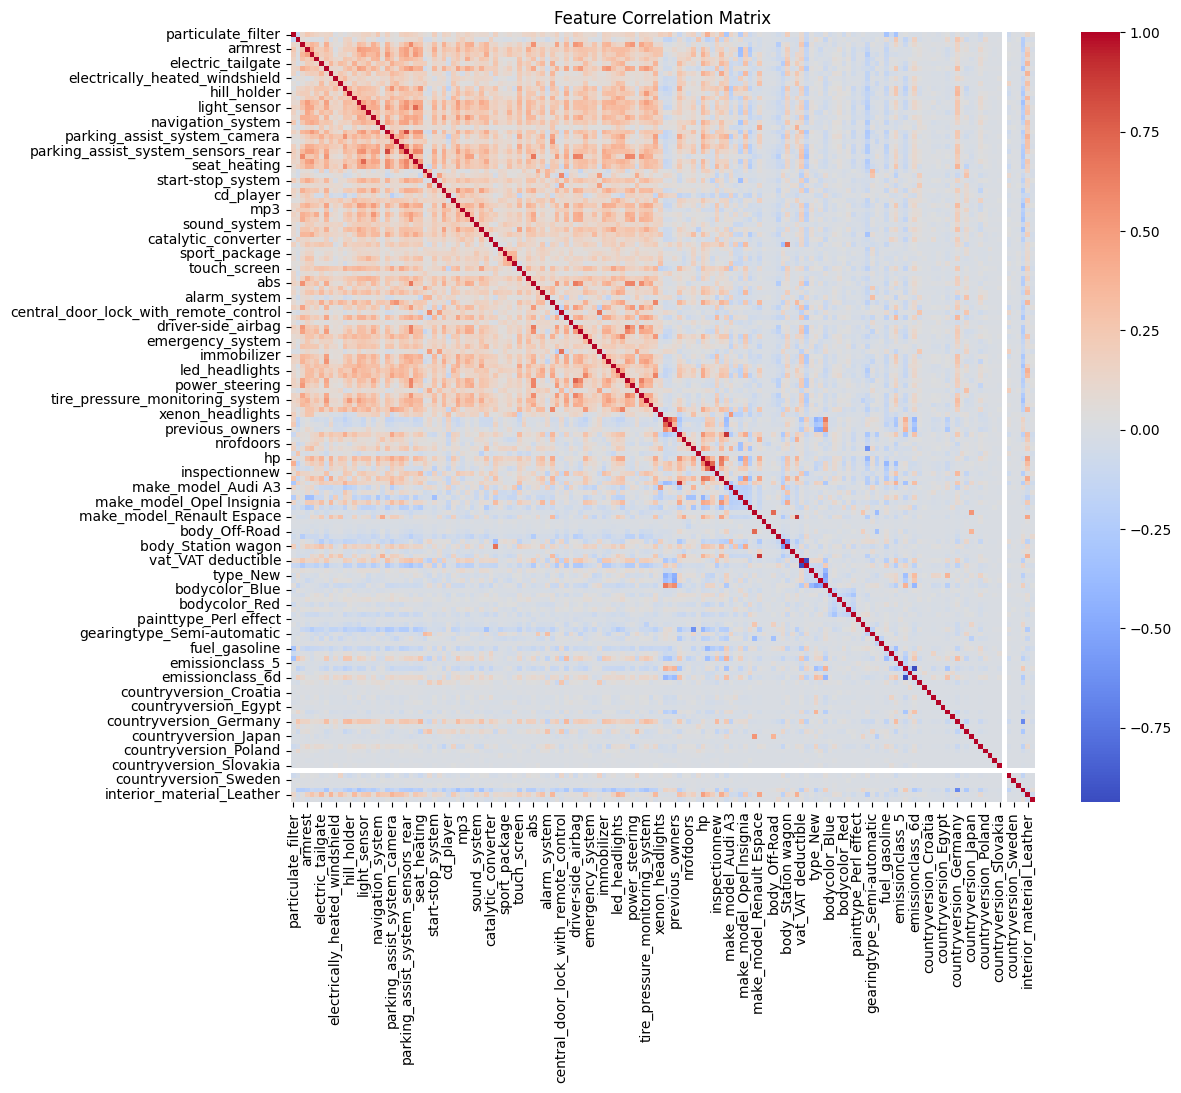

In [265]:
# Compute correlation matrix
corr_matrix = pd.DataFrame(X_train_sscaled, columns=X_train.columns).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Quite a lot of multicolinearity, can affect performance of linear models. Have already tried feature selection in Lasso, but this still kept most of the features. Try a PCA to reduce dimensionality?

In [266]:
from sklearn.decomposition import PCA


In [267]:
# Perform PCA (keep components that explain 95% of the variance)
pca = PCA(n_components=0.95)  # Retain enough components to explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check how many components PCA selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 120


In [268]:
# Explained variance ratio by each component
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Cumulative variance explained by all components
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")

Explained variance ratio: [0.11990172 0.05307659 0.04035307 0.02836544 0.02477589 0.02031545
 0.01828892 0.01684319 0.01596855 0.0150529  0.01377594 0.01254745
 0.01190755 0.0115603  0.01029509 0.01006314 0.00983247 0.00956402
 0.00898398 0.00885    0.00857401 0.00848057 0.0083454  0.00810064
 0.00780849 0.00774917 0.00754384 0.00740703 0.00737235 0.0072045
 0.00714184 0.00709649 0.00700886 0.00692785 0.00680851 0.006747
 0.00670112 0.00667027 0.00656171 0.00652368 0.00648099 0.0064559
 0.00644165 0.00641005 0.00639948 0.00637227 0.00635645 0.00633086
 0.00629647 0.00628773 0.00624197 0.00612326 0.00602662 0.00599894
 0.00590952 0.00583959 0.00581075 0.00576925 0.00569848 0.0055686
 0.00551183 0.00543555 0.00536215 0.00523188 0.00519184 0.00514736
 0.0050836  0.00491403 0.00489498 0.00479246 0.00471876 0.0046518
 0.0046125  0.00452895 0.00446509 0.00439069 0.00430369 0.00425761
 0.00420265 0.00410292 0.00401397 0.00395937 0.00391299 0.00386983
 0.00381015 0.00378566 0.00373612 0.003687

In [269]:
# Perform another gridsearch this time using PCA data
# Perform GridSearch to try and optimise alpha for ridge and lasso regressions
# For Ridge Regression
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100,1000]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train_pca, y_train)
print("Best Ridge alpha:", ridge_grid.best_params_['alpha'])

# For Lasso Regression
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_pca, y_train)
print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

Best Ridge alpha: 1000


c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.399e+09, tolerance: 5.319e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+10, tolerance: 5.266e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

Best Lasso alpha: 10


In [270]:
# have a look at performance metrics across the grid for both models
# Ridge Regression results
ridge_results = pd.DataFrame(ridge_grid.cv_results_)

# Lasso Regression results
lasso_results = pd.DataFrame(lasso_grid.cv_results_)

In [271]:
# Select relevant columns
ridge_metrics = ridge_results[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Convert negative MSE to positive MSE
ridge_metrics['mean_test_MSE'] = -ridge_metrics['mean_test_score'] # calculate the positive version of the MSE by negating the mean_test_score (used neg_MSE in our GridSearchCV)
ridge_metrics['std_test_MSE'] = ridge_metrics['std_test_score']
ridge_metrics['meant_test_RMSE'] = ridge_metrics['mean_test_MSE'] ** 0.5 # root MSE is good because its on the same scale as the target variable
# Display the metrics
print("Ridge Regression Performance Metrics:")
print(ridge_metrics[['param_alpha', 'mean_test_MSE', 'std_test_MSE','meant_test_RMSE', 'rank_test_score']].sort_values(by = 'rank_test_score'))

Ridge Regression Performance Metrics:
   param_alpha  mean_test_MSE  std_test_MSE  meant_test_RMSE  rank_test_score
5      1000.00   7.532938e+06  3.907181e+05      2744.619841                1
4       100.00   8.060990e+06  1.076656e+06      2839.188201                2
3        10.00   3.863169e+07  3.636545e+07      6215.439932                3
2         1.00   2.350274e+08  1.833536e+08     15330.602076                4
1         0.10   3.641063e+08  2.536204e+08     19081.568585                5
0         0.01   3.839624e+08  2.643521e+08     19594.958916                6


C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\3819835117.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_metrics['mean_test_MSE'] = -ridge_metrics['mean_test_score'] # calculate the positive version of the MSE by negating the mean_test_score (used neg_MSE in our GridSearchCV)
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\3819835117.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_metrics['std_test_MSE'] = ridge_metrics['std_test_score']
C:\Users\BalintStewart\AppDa

In [272]:
# Select relevant columns
lasso_metrics = lasso_results[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Convert negative MSE to positive MSE
lasso_metrics['mean_test_MSE'] = -lasso_metrics['mean_test_score']
lasso_metrics['std_test_MSE'] = lasso_metrics['std_test_score']
lasso_metrics['meant_test_RMSE'] = lasso_metrics['mean_test_MSE'] ** 0.5 # root MSE is good because its on the same scale as the target variable

# Display the metrics
print("Lasso Regression Performance Metrics:")
print(lasso_metrics[['param_alpha', 'mean_test_MSE', 'std_test_MSE', 'meant_test_RMSE','rank_test_score']].sort_values(by = 'rank_test_score'))

Lasso Regression Performance Metrics:
   param_alpha  mean_test_MSE  std_test_MSE  meant_test_RMSE  rank_test_score
5      10.0000   7.549300e+06  4.219842e+05      2747.598945                1
6     100.0000   8.470320e+06  4.703899e+05      2910.381450                2
4       1.0000   3.301413e+07  5.028917e+07      5745.792284                3
3       0.1000   2.906441e+08  2.274688e+08     17048.287421                4
2       0.0100   3.741193e+08  2.606659e+08     19342.164372                5
1       0.0010   3.834312e+08  2.646270e+08     19581.399141                6
0       0.0001   3.843719e+08  2.650311e+08     19605.404210                7


C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_metrics['mean_test_MSE'] = -lasso_metrics['mean_test_score']
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_metrics['std_test_MSE'] = lasso_metrics['std_test_score']
C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_17484\987804785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

PCA with 95% variance explained is performing slightly worse than using feature set. Might need to look for non-linear relationships next?